In [1]:
import os
import random
import cv2
from PIL import Image
from shutil import copyfile, rmtree
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
#
imges_dir = '../input/face-mask-detection/images/'
annotations_dir = '../input/face-mask-detection/annotations/'

print(f"there are {len(os.listdir(imges_dir))} images")
print(f"there are {len(os.listdir(imges_dir))} annotations")


there are 853 images
there are 853 annotations


PreProcessing

In [3]:
#Create list of paths for image and anotation

images_path = []
annotations_path = []

for dirname, _, filenames in os.walk('../input/face-mask-detection'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if file_path[-3:] == 'xml':
            annotations_path.append(file_path)
        else:
            images_path.append(file_path)
            
print(len(images_path),len(annotations_path))

853 853


In [4]:
import pandas as pd
import xml.etree.ElementTree as ET

# Create a DataFrame and load annotation data
df = pd.DataFrame(columns=['file_name', 'label', 'xmin', 'ymin', 'xmax', 'ymax'])

for xml_file in annotations_path:
    tree = ET.parse(xml_file)
    root = tree.getroot()
    file_name = root.find('filename').text

    for obj in root.findall('object'):
        row = {
            'file_name': file_name,
            'label': obj.find('name').text,
            'xmin': int(obj.find('bndbox').find('xmin').text),
            'ymin': int(obj.find('bndbox').find('ymin').text),
            'xmax': int(obj.find('bndbox').find('xmax').text),
            'ymax': int(obj.find('bndbox').find('ymax').text)
        }
        df = df.append(row, ignore_index=True)
df

,file_name,label,xmin,ymin,xmax,ymax
0,maksssksksss737.png,with_mask,28,55,46,71
1,maksssksksss737.png,with_mask,98,62,111,78
2,maksssksksss737.png,mask_weared_incorrect,159,50,193,90
3,maksssksksss737.png,with_mask,293,59,313,80
4,maksssksksss737.png,with_mask,352,51,372,72
...,...,...,...,...,...,...
4067,maksssksksss13.png,with_mask,229,53,241,72
4068,maksssksksss138.png,with_mask,51,144,128,239
4069,maksssksksss138.png,with_mask,147,169,217,233
4070,maksssksksss138.png,with_mask,224,92,309,186


In [5]:
#Cropped image based on (xmin, ymin, xmax, ymax)
BASE_DIR_IMG = '../input/face-mask-detection/images/'

def crop_image(filename, xmin, ymin, xmax, ymax, is_img_arr=False):
    if is_img_arr is False:
        img = Image.open(BASE_DIR_IMG + filename)
        img_arr = np.array(img)
    else:
        img_arr = np.array(filename)
    # cropping
    img_cropped = img_arr[ymin:ymax, xmin:xmax, :3]
    return img_cropped

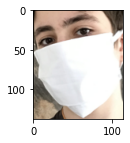

In [6]:
# Test our crop_image function
row = df.iloc[200]
im_cropped = crop_image(row.file_name, row.xmin, row.ymin, row.xmax, row.ymax)
# plot image cropped
plt.figure(figsize=(2,2))
plt.imshow(im_cropped)
plt.show()

In [7]:
images = []
labels = []
for i in range(len(df)):
    row = df.iloc[i]
    im_cropped = crop_image(row.file_name, row.xmin, row.ymin, row.xmax, row.ymax)
    im_resized = cv2.resize(im_cropped, (50, 50))
    im_resized = im_resized / 255.0
    images.append(im_resized)
    labels.append(row.label)
len(images), len(labels)

(4072, 4072)

In [8]:
le = preprocessing.LabelEncoder()
labels_encoder = le.fit_transform(labels)
targets = np.array(labels_encoder)
targets.shape

(4072,)

In [9]:
X_data, X_test, y_data, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)
len(X_data), len(X_test)

(3664, 408)

In [10]:
# validation set
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(2931, 2931, 733, 733)

In [11]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):

  train_datagen = ImageDataGenerator(rescale=1./255,              
                                     )


  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 

  validation_datagen = ImageDataGenerator(rescale=1./255)


  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 


  return train_generator, validation_generator


In [16]:

training_images = np.array(X_train, dtype='float64')
training_labels = np.array(y_train, dtype='float64')
validation_images = np.array(X_val, dtype='float64')
validation_labels = np.array(y_val, dtype='float64')

train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

In [17]:
def create_model():

  model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32,(3,3), strides=(1,1), padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(32,(5,5), strides=(1,1), padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(data_format="channels_last"),
        tf.keras.layers.Dense(300, activation="selu"),
        tf.keras.layers.Dense(100, activation="selu"),
        tf.keras.layers.Dense(26, activation="softmax")
      ])
  

  model.compile(optimizer = 'nadam',
                loss = "sparse_categorical_crossentropy",
                metrics=['accuracy'])     
  
  return model

In [18]:
model = create_model()

In [19]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

2022-10-05 07:28:05.365336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-10-05 07:28:10.698535: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
92/92 [==============================] - 3s 11ms/step - loss: 0.6969 - accuracy: 0.7711 - val_loss: 0.5148 - val_accuracy: 0.8090
Epoch 2/15
92/92 [==============================] - 1s 9ms/step - loss: 0.5764 - accuracy: 0.7728 - val_loss: 0.4382 - val_accuracy: 0.7817
Epoch 3/15
92/92 [==============================] - 1s 9ms/step - loss: 0.4198 - accuracy: 0.8028 - val_loss: 0.3153 - val_accuracy: 0.8868
Epoch 4/15
92/92 [==============================] - 1s 9ms/step - loss: 0.3740 - accuracy: 0.8710 - val_loss: 0.2213 - val_accuracy: 0.9400
Epoch 5/15
92/92 [==============================] - 1s 9ms/step - loss: 0.2347 - accuracy: 0.9239 - val_loss: 0.3262 - val_accuracy: 0.8445
Epoch 6/15
92/92 [==============================] - 1s 9ms/step - loss: 0.2384 - accuracy: 0.9266 - val_loss: 0.2103 - val_accuracy: 0.9372
Epoch 7/15
92/92 [==============================] - 1s 9ms/step - loss: 0.2156 - accuracy: 0.9294 - val_loss: 0.1927 - val_accuracy: 0.9400
Epoch 8/15
92/92 [=

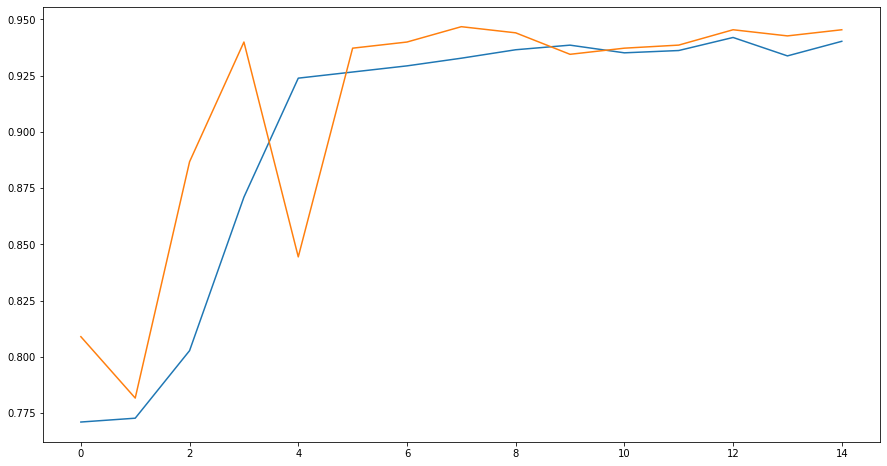

In [26]:
# Plotting Model Accuracy 
plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [39]:
from sklearn.metrics import classification_report

In [40]:
test_images = np.array(X_test, dtype='float64')
test_labels = np.array(y_test, dtype='float64')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow(x=test_images,
                                   y=test_labels,
                                   batch_size=32)

scores = model.evaluate(test_generator)

13/13 [==============================] - 0s 3ms/step - loss: 0.2033 - accuracy: 0.9363


In [41]:
y_preds = model.predict(test_images).argmax(axis=1)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.78      0.99      0.87       317
           2       0.00      0.00      0.00        75

    accuracy                           0.77       408
   macro avg       0.26      0.33      0.29       408
weighted avg       0.60      0.77      0.68       408

